# Understanding community response to Warburton MTB project
> 
- layout: posts
- date:   2021-10-21 20:39:54 +1000
- categories: programming
- classes: wide
- author: Lachlan Grose
- author_profile: true
- excerpt_separator: <!--more--> 

The Mountain bike park planned for Warburton has been extremely controversial with social and environmental concerns regularly voiced by critics. An Environment Effects Statement, a comprehensive study of the environmental impacts of large infastructure projects was ordered. One of the steps of the ESS is a call for community feedback. The community feedback for the Warburton MTB project was conducted in late 2021 and the responses were made public in early 2022. There were over 2500 submissions from the general public, including mountain bike riders and environmentalists. In this post I will use some basic machine learning techniques for automatically analysing the text in the submissions with the aim of understanding whether the overall feedback was positive or negative. To do this the ess results needed to be downloaded from the repository holding them, the pdf files need to be converted into plain text and the results analysed for the sentiment. All of this work will be performed with Python.


## Downloading and reading PDF files

The community submissions for the ESS can be found [here](!https://engage.vic.gov.au/project/warburton-iac/page/warburton-IAC-submissions). Taking a look at the individual files we can see that each file containing the submissions have the same structure https://engage.vic.gov.au/download/document/23728 where the number 23728 increased for each submission file.
Looking at the submissions the structure of the submissions are similar layout.

![image.png](./img/warburton_ess_example_submission.png)

To read a PDF using Python there are numerous libraries available. My preference is pdfplumber because it has an easy to use API to adapt it to particular use cases. To read a PDF using pdfplumber we just need to use the following code:


In [2]:
import ssl
import urllib
import pdfplumber
import io
all_text=''
url = 'http://engage.vic.gov.au/download/document/23671'
gcontext = ssl.SSLContext()  
req=urllib.request.Request(url)

resp=urllib.request.urlopen(req,context=gcontext)
data = resp.read()
with pdfplumber.open(io.BytesIO(data)) as pdf:
    for p in pdf.pages:
        text = p.extract_text()
        all_text+=text.replace('\n',' ')
print(all_text[:1000])

Submission Cover Sheet 1 Warburton Mountain Bike Destination Inquiry and Advisory  Committee  Request to be heard?: No Full Name: Andrew Gard Organisation: Affected property: Attachment 1: Attachment 2: Attachment 3: Comments: I believe this project should go ahead. It will create a wider community of mtb riders  and also allow new people to get out and about in the nature on the trails of  Warburton and surrounds.  I believe it will bring more money into the local  communities with hopefully, new businesses being able to open and create new job  opportunities.  Thanks, Andy.Submission Cover Sheet 2 Warburton Mountain Bike Destination Inquiry and Advisory  Committee  Request to be heard?: No Full Name: Mathew Stoessiger Organisation: Affected property: Attachment 1: Attachment 2: Attachment 3: Comments: I support the Warburton Mountain Bike Destination Project, the project will create  jobs and enrich peoples lives through outdoor activities with minimal impact on the  environment.Subm

Where we are downloading the PDF as a binary data file using urllib. We need to provide an empty ssl certificate to avoid missing certificate errors. If you wanted to reuse this code and adapt it to a different dataset you may not need this, or you may need to provide a valid certificate depending on the security of the source website.  

`pdfplumber.open()` provides an object for accessing different elements of the pdf. For this example we want to extract all of the text from every page. This can be done by iterating over the pages in the pdf and using extract_text to retrieve the text. Here I am just going to use a string to store all of the text, because there is no guarentee that each page is a new submission. Long submissions may have multiple page comments and we ideally want to keep these together.

We can apply this process to all of the submissions by iterating over the filename. We can change the url of the submission using Pythons fstring formatting. Unfortunately, the submissions files are not numbered consecutively and some do not exist, to avoid crashing the code we can wrap the code in a try/except block. 


In [23]:
all_text = ''
for i in range(23671,23728):
    url =  f'http://engage.vic.gov.au/download/document/{i}'
    try:
        gcontext = ssl.SSLContext()  
        req=urllib.request.Request(url)

        resp=urllib.request.urlopen(req,context=gcontext)
        data = resp.read()
        with pdfplumber.open(io.BytesIO(data)) as pdf:
            for p in pdf.pages:
                text = p.extract_text()
                all_text+=text.replace('\n',' ')
        #
        # import pdf files and save to text
        # 
    except BaseException as e:
        print(e, url)

HTTP Error 404: Not Found http://engage.vic.gov.au/download/document/23692
HTTP Error 404: Not Found http://engage.vic.gov.au/download/document/23694
HTTP Error 404: Not Found http://engage.vic.gov.au/download/document/23711
HTTP Error 404: Not Found http://engage.vic.gov.au/download/document/23712


In [27]:
# save all of the comments to a file to avoid re-downloading
import pickle
with open('warburton.pkl', 'wb') as f:
    pickle.dump(all_text,f)


In [3]:
import pickle
with open('warburton.pkl', 'rb') as f:
    all_text = pickle.load(f)#pickle.dump(all_text,f)

We now have a large string with all of the submission. We can see that every submission has the title page 'Submission Cover Sheet'. To break the submissions into categories we can split the string into separate strings using the string function split.


In [4]:
submissions = all_text.split('Submission Cover Sheet')

In [5]:
submissions[1]

' 1 Warburton Mountain Bike Destination Inquiry and Advisory  Committee  Request to be heard?: No Full Name: Andrew Gard Organisation: Affected property: Attachment 1: Attachment 2: Attachment 3: Comments: I believe this project should go ahead. It will create a wider community of mtb riders  and also allow new people to get out and about in the nature on the trails of  Warburton and surrounds.  I believe it will bring more money into the local  communities with hopefully, new businesses being able to open and create new job  opportunities.  Thanks, Andy.'

Looking at an individual submission we can see that the text following **Comment:** is what we are interested in. We can extract all of the text following the comments by spliting the text after 'Comments:'.

In [6]:
comments = []
for submission in submissions:
    if 'Comments:' in submission:
        comments.append(submission.split('Comments:')[1])

In [7]:
print(f'There are {len(comments)} submissions')

There are 2548 submissions


## Sentiment analysis
We now have a list containing the text for each comment. Now we want to determine whether the overall sentiment of the comment is positive or negative. Sentiment analysis is one of the techniques of natural language processing. Different models exist and its generally best to build a model using a training database. For this example, we will use a pre-trained model from the natural language tool kit. Before using the sentiment analysis we need to remove any uncessary words from the comments, these include "a, an, the for" etc.


In [8]:
import nltk
from nltk.corpus import stopwords 
from nltk.sentiment import SentimentIntensityAnalyzer
# download the nltk files for the first run
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
comments_no_stop_words = []
for comment in comments:
    comments_no_stop_words.append([w for w in comment.split(' ') if not w.lower() in stop_words])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lgrose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lgrose\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(' '.join(comments_no_stop_words[0]))

{'neg': 0.0, 'neu': 0.662, 'pos': 0.338, 'compound': 0.9062}

In [10]:
import pandas as pd
sentiment = pd.DataFrame([['',0,0,0,0]],columns=['comment','neg','neu','pos','compound'])
sia = SentimentIntensityAnalyzer()
for i, comment in enumerate(comments_no_stop_words):
    r = sia.polarity_scores(' '.join(comment))
    sentiment.loc[i,'comment'] = comments[i] 
    sentiment.loc[i,'neg'] = r['neg']
    sentiment.loc[i,'neu'] = r['neu']
    sentiment.loc[i,'pos'] = r['pos']
    sentiment.loc[i,'compound'] = r['compound']

## Interpreting the results
The results of the sentiment intensity analyser are four numbers specifying the negative, positive, neutral and compound sentiment. The initial objective was to determine what the split between negative and positive submissions for the Warburton mountain bike park. To do this we need to first validate how well the method works by looking at submissions for different sentiments. 

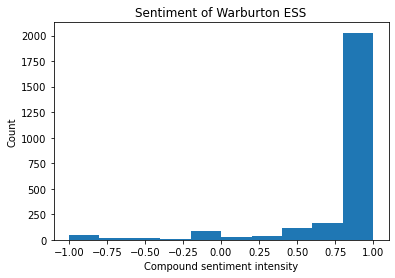

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
ax.hist(sentiment['compound'])
ax.set_title('Sentiment of Warburton ESS')
ax.set_xlabel('Compound sentiment intensity')
_ =ax.set_ylabel('Count')

Looking at the distribution of compound sentiment intensity we can see that the majority of responses have a positive sentiment (compound intensity is positive). We can do a quick validation of this assesement by randomly selecting some comments within different sentiment bands to get an understanding of the results. To do this we will mask the pandas dataframe using a boolean mask and then use the random method to sample from the resulting dataframe.

### Sentiment Intensity > 0.8

In [13]:
old_column_width = pd.options.display.max_colwidth 
pd.options.display.max_colwidth = None
sentiment.loc[sentiment['compound']>0.8,['comment','compound']].sample(2)
# pd.options.display.max_colwidth = old_column_widt2

,comment,compound
204,"My submission is simply a short commentary on the contents of the EES and the overall project direction, along with a personal story about the positive impacts of mountain bike trails. First of all, I do not claim to be an expert on any of the considerations considered in the EES –biodiversity, water, cultural heritage, land use, socio-economic or transport. However, upon digesting the contents of the report, it is apparent to me that the Warburton Mountain Bike Destination (WMBD) team have engaged with a broad array of experts in their field and have used that expertise to prepare an incredibly detailed statement of the effects of the project. I have seen firsthand the benefits of large, sanctioned trail centres. I grew up in Alberta, Canada, and through the fantastic trail networks in Kananaskis Country at Moose Mountain and West Bragg Creek, I had the opportunity to get involved in mountain biking from a young age. That opportunity resulted in me becoming a keen mountain biker, and as I spent long hours and days on my bike in Kananaskis, I developed a love for and connection to the area. That connection had two significant impacts on my life: 1. I care deeply about the beautiful natural places that I am so fortunate to enjoy on my mountain bike. When there were proposals to clearfell an area of Kananaskis near the mountain bike trails, I along with many mountain bikers voiced opposition to the project. It was clear that the members of the mountain bike community had become connected with the land, and did not want to see it destroyed. Many of us would not otherwise have known or cared about the logging that was to occur, but mountain biking taught us about the environment, and we cared enough to make a difference when it was threatened 2. Speaking of the mountain biking community, we all came together around a shared passion. This generated many connections for all of us that we may not otherwise have had. In this age of profound disconnection and isolation, we should be taking any opportunity we can find to build these sorts of communities and let them thrive. In the years since I have moved to Victoria, I have used mountain biking as a vehicle to get to know the incredible beauty of this state. I would love to see more Victorians get the opportunity to get on their bikes and through the experience of mountain biking develop deep connections with their fellow mountain bikers, and the natural beauty around them. I would love to see more people making a living off nature-based tourism rather than resource extraction. In fact, if we consider the opportunities of investing in initiatives like this that would create jobs that do not require constant resource depletion, it could be argued that the environmental impact of building the trail centre would be a net positive. And lastly, as a mountain biker from overseas, I would love to see more mountain bikers come to experience all that Victoria has to offer.",0.9978
2417,"Mountain biking is a growing sport and pastime for many people of all ages and sexes. It is a great way to exercise, socialise and have fun. It is also fantastic to get out into nature. Which just about all mountain bikers love and respect. As it is a growing sport there are a big lack of places to ride. We often travel hours to get to a place to ride. Having another place as awesome as Warburton to ride would be incredible and also take some pressure off other riding places and also help stop illegal tracks being built. Looking at Tasmania as an example of Mtb and locals coexisting together very well this can only be a great thing for Warburton and mtbrs alike.",0.9761


### Sentiment Intensity > 0.6 and < 0.8

In [14]:
sentiment.loc[(sentiment['compound']<0.8) & (sentiment['compound']>0.6),['comment','compound']].sample(2)

,comment,compound
764,I believe that this project will be a great economic and social benefit for the area.,0.7964
2389,I love exploring new places on my bike and this would be close to home,0.6369


### Sentiment Intensity > -0.2 and < 0.2

In [15]:
sentiment.loc[(sentiment['compound']<0.2) & (sentiment['compound']>-0.2),['comment','compound']].sample(2)

,comment,compound
317,"The northern trail network located primarily in the Yarra Ranges National Park, making up just over third of the trails, should be abandoned. The southern trail network, just under two-thirds of the trails, occurs mostly in state forest and could proceed with some modification. The key issues are with proposed tracks in the Yarra Ranges National Park. National Parks are supposed to give nature the strongest of protections, yet parts of the project will cause undue harm to very important ecological values, removing important habitat, impacting on threatened plants animals and communities, water catchments while increasing pest species. This is neglectful of heritage and socio-economic values and the integrity of national parks.",0.0000
958,"Mountain bike tourism is absolutely booming and will continue to do so. What has been designed for Warburton will be an absolute boon for the region and bring all manner of economic and community benefit —as was shown in the work done prior to the EES. Now with the EES documents completed and more in-depth empirical work completed than any other mountain bike trail network in the world, the data shows that there will be almost zero negative impact on the environment or the community. If this project does not go forward it will be an absolute travesty and a huge loss for the folks who live in Warburton as they stand to gain the most from these trails.",-0.1832


### Sentiment Intensity > -1 and < 0.2

In [19]:
sentiment.loc[(sentiment['compound']<0.2) & (sentiment['compound']>-1),['comment','compound']].sample(2)

,comment,compound
1361,"Millions of Australians now ride mountain bikes for recreation and fitness, instead of spending millions of dollars flying overseas and to Tasmania to ride world class trails let’s build something in our own backyard! It would be a disaster if this project didn’t get off ground due to a handful of ill informed and unhappy people who aren’t interested in others being happy. “Build it and they shall come…… “",-0.3595
1554,I object to the development of new mountain bike trails in Warburton in the Yarra Ranges National Park. It will negatively impact on local wildlife that the park is set out to protect and extra human traffic will bring further environmental stress upon an already underfunded National Parks system in Victoria.,-0.0516


A common technique for visualising text datasets is to generate an image with all of the unique words weighted by their frequency of occurence. These word clouds can help to identify which words are most commonly used in a text to give some idea about the meaning. 

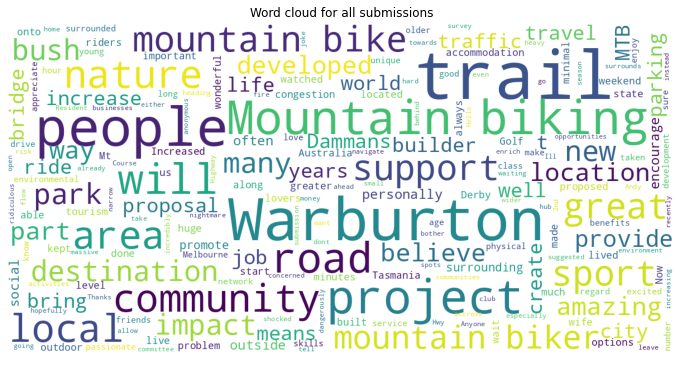

In [54]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40, 
    scale=3,
    random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(sentiment['comment']))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Word cloud for all submissions')
ax.imshow(wordcloud)

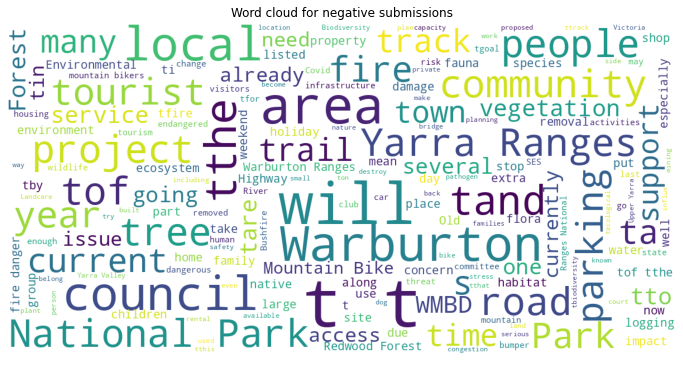

In [55]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40, 
    scale=3,
    random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(sentiment.loc[sentiment['compound']<-.5,'comment']))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title('Word cloud for negative submissions')
ax.axis('off')
ax.imshow(wordcloud)

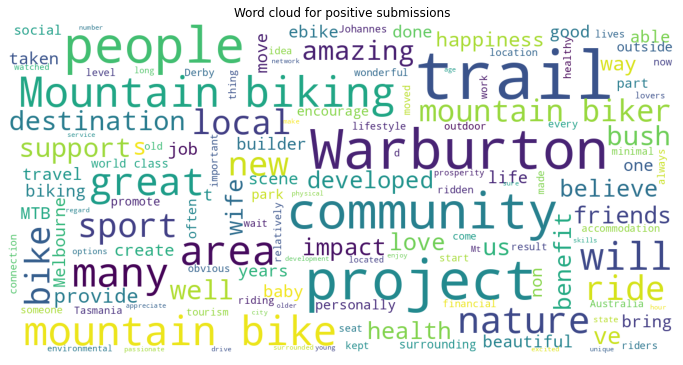

In [56]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40, 
    scale=3,
    random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(sentiment.loc[sentiment['compound']>0,'comment']))

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title('Word cloud for positive submissions')
ax.axis('off')
ax.imshow(wordcloud)

## Summary
From the results we can see that the majority of submissions were presented in a positive tone, indicating that these submissions were positive towards the development of the Mountain bike park as it is difficult to write a response with a positive tone that has a negative meaning. Some of the submissions classified as negative are negative towards the process or delays in building the park. Other negative sentiment submissions are true critics of the mountain bike park. 

In this post I have employed very basic tools in natural language processing applying a generic model to a fairly specific problem. For this reason, the results should only be viewed as a coarse indication of the true sentiment in the submissions. The goal for this example, was to quickly (and automatically) understand whether there were more positive responses or negative responses. I did not want to read every submission. 